# Parameter calibration of a cardiac potassium channel model
#### &copy; 2022 SUNY Korea

### 1. Import required packages
* `matplotlib.pyplot`: Statistic visualization
* `pandas`: Data analysis toolkit
* `numpy`: N-dimensional array
* `myokit`: Analysis of cardiac myocytes
* `pints`: Probabilistic Inference on Noisy Time-Series
* `tqdm`: Progress visualization

If those packages are not installed, run `python3 -m pip install -r requirements.txt` on terminal.

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib
import myokit
import pints
import os

#### 1-1. matplotlib visualization setting
Change the variable of `matplotlib.rcParams['figure.dpi']` to change the resolution (DPI) of a graphical image.

In [2]:
matplotlib.rcParams['figure.dpi'] = 300
plt_font = {'fontname': 'DejaVu Serif'}

Current DPI: 300.0


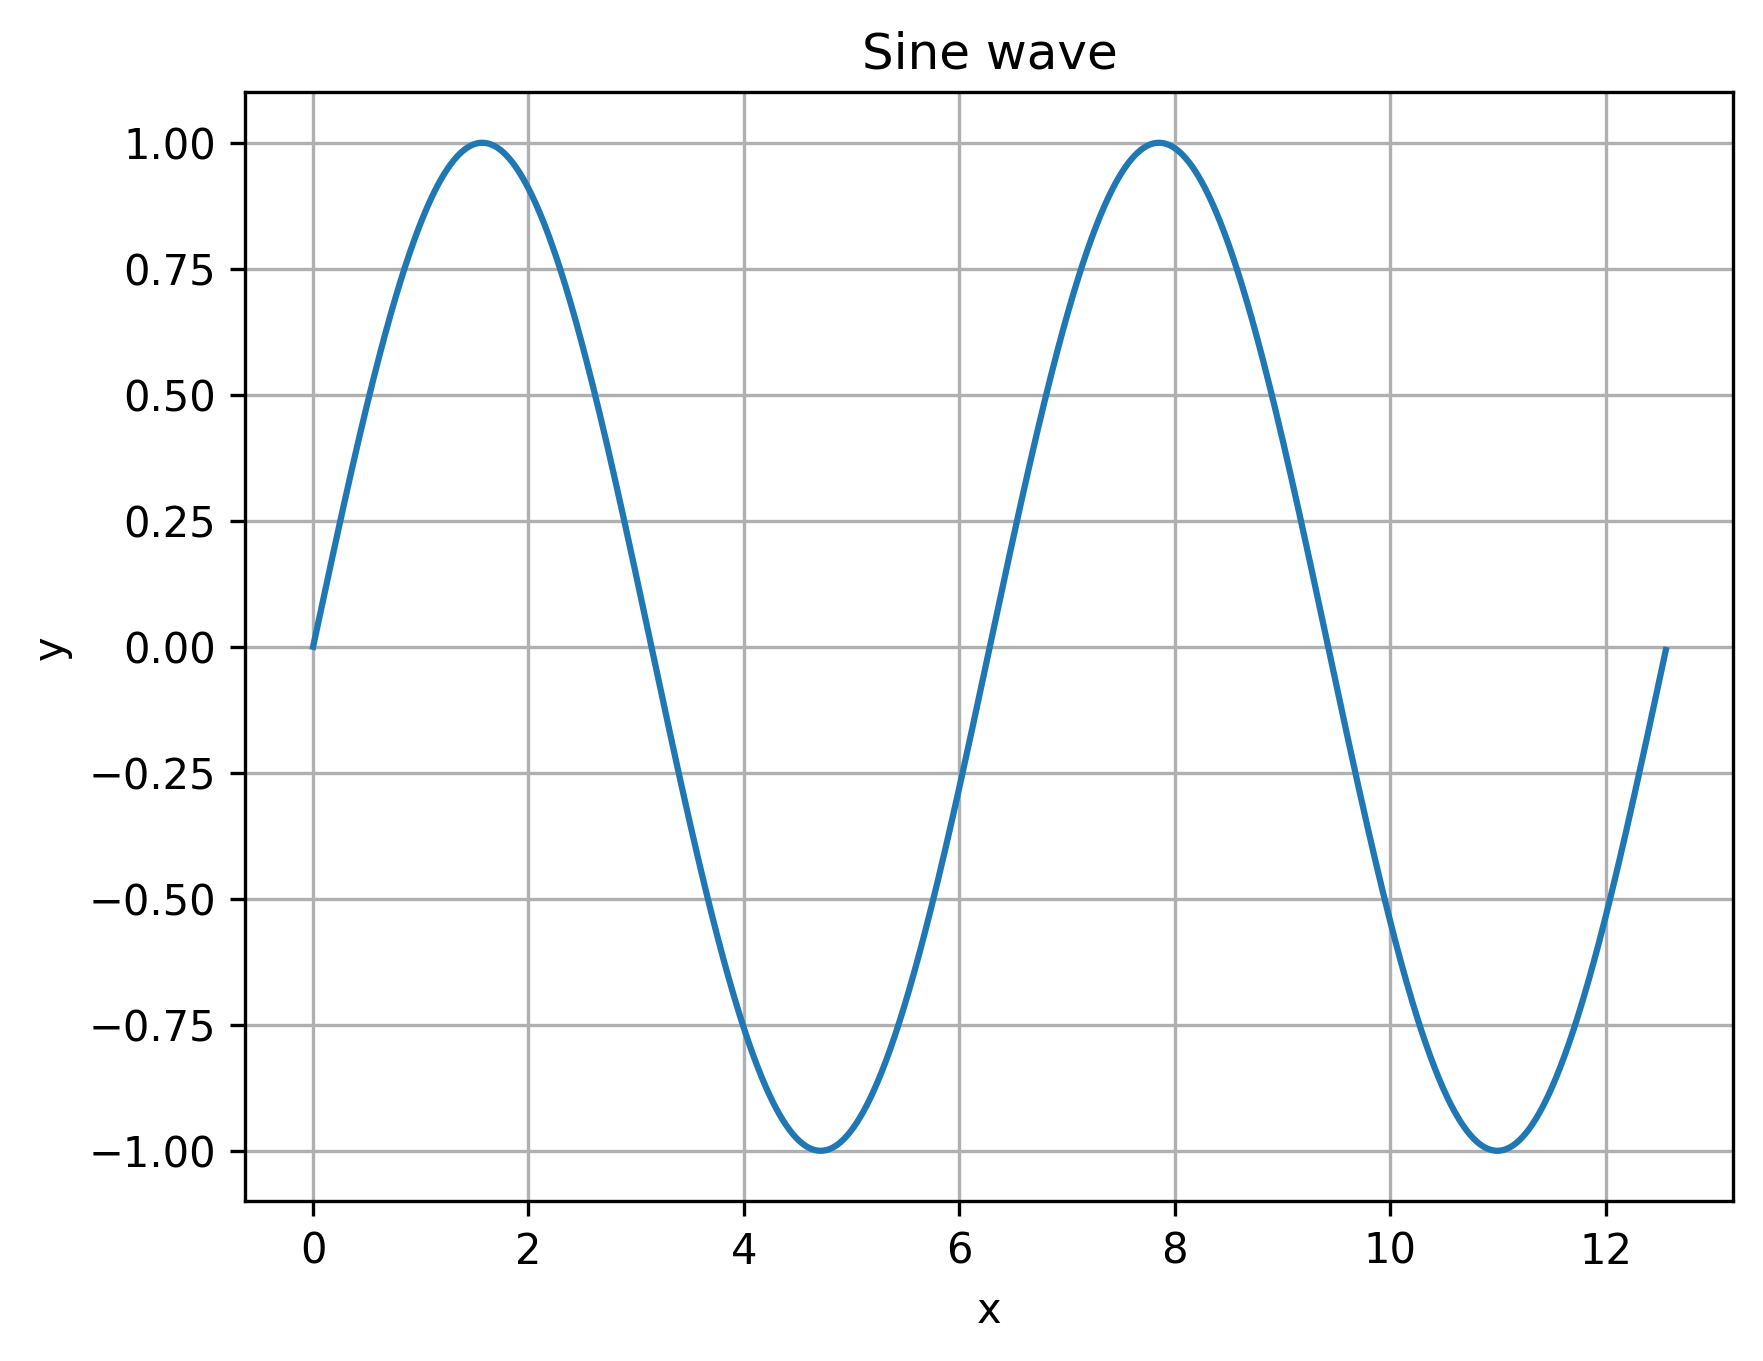

In [3]:
def sample():
    print("Current DPI:", matplotlib.rcParams['figure.dpi'])
    t = np.arange(0.0, 4.0 * np.pi, 0.01)
    s = np.sin(t)
    fig, ax = plt.subplots()
    ax.plot(t, s)
    ax.set(xlabel='x', ylabel='y', title='Sine wave')
    ax.grid()
    plt.show()

sample()

### 2. Declare filepath
Declare filepaths using dictionary data structure for code simplification.

In [4]:
models = {
    'model-A':"../models/model-A.mmt",
    'model-B':"../models/model-B.mmt",
    'model-C':"../models/model-C.mmt",
    'model-15':"../models/model-15.mmt",
    'model-16':"../models/model-16.mmt",
    'model-25':"../models/model-25.mmt"
}

protocols = {
    "sine-wave":"../protocols/sine-wave.csv",
    "staircase-ramp":"../protocols/staircase-ramp.csv",
    "reduced-sine-wave":"../protocols/reduced-sine-wave.csv",
    "reduced-staircase-ramp":"../protocols/reduced-staircase-ramp.csv",
    "ap":"../protocols/ap.csv",
    }

synthetic_path = "../data/synthetic-data/synthetic-{}-{}.csv" # Form: synthetic-protocol-model.csv
output_path = "../data/output/calibration-{}-{}.csv"          # Form: calibration-protocol-model.csv

### 3. Simulation testing
Check if the myokit successfully loads `.csv` file and simulates the protocol.

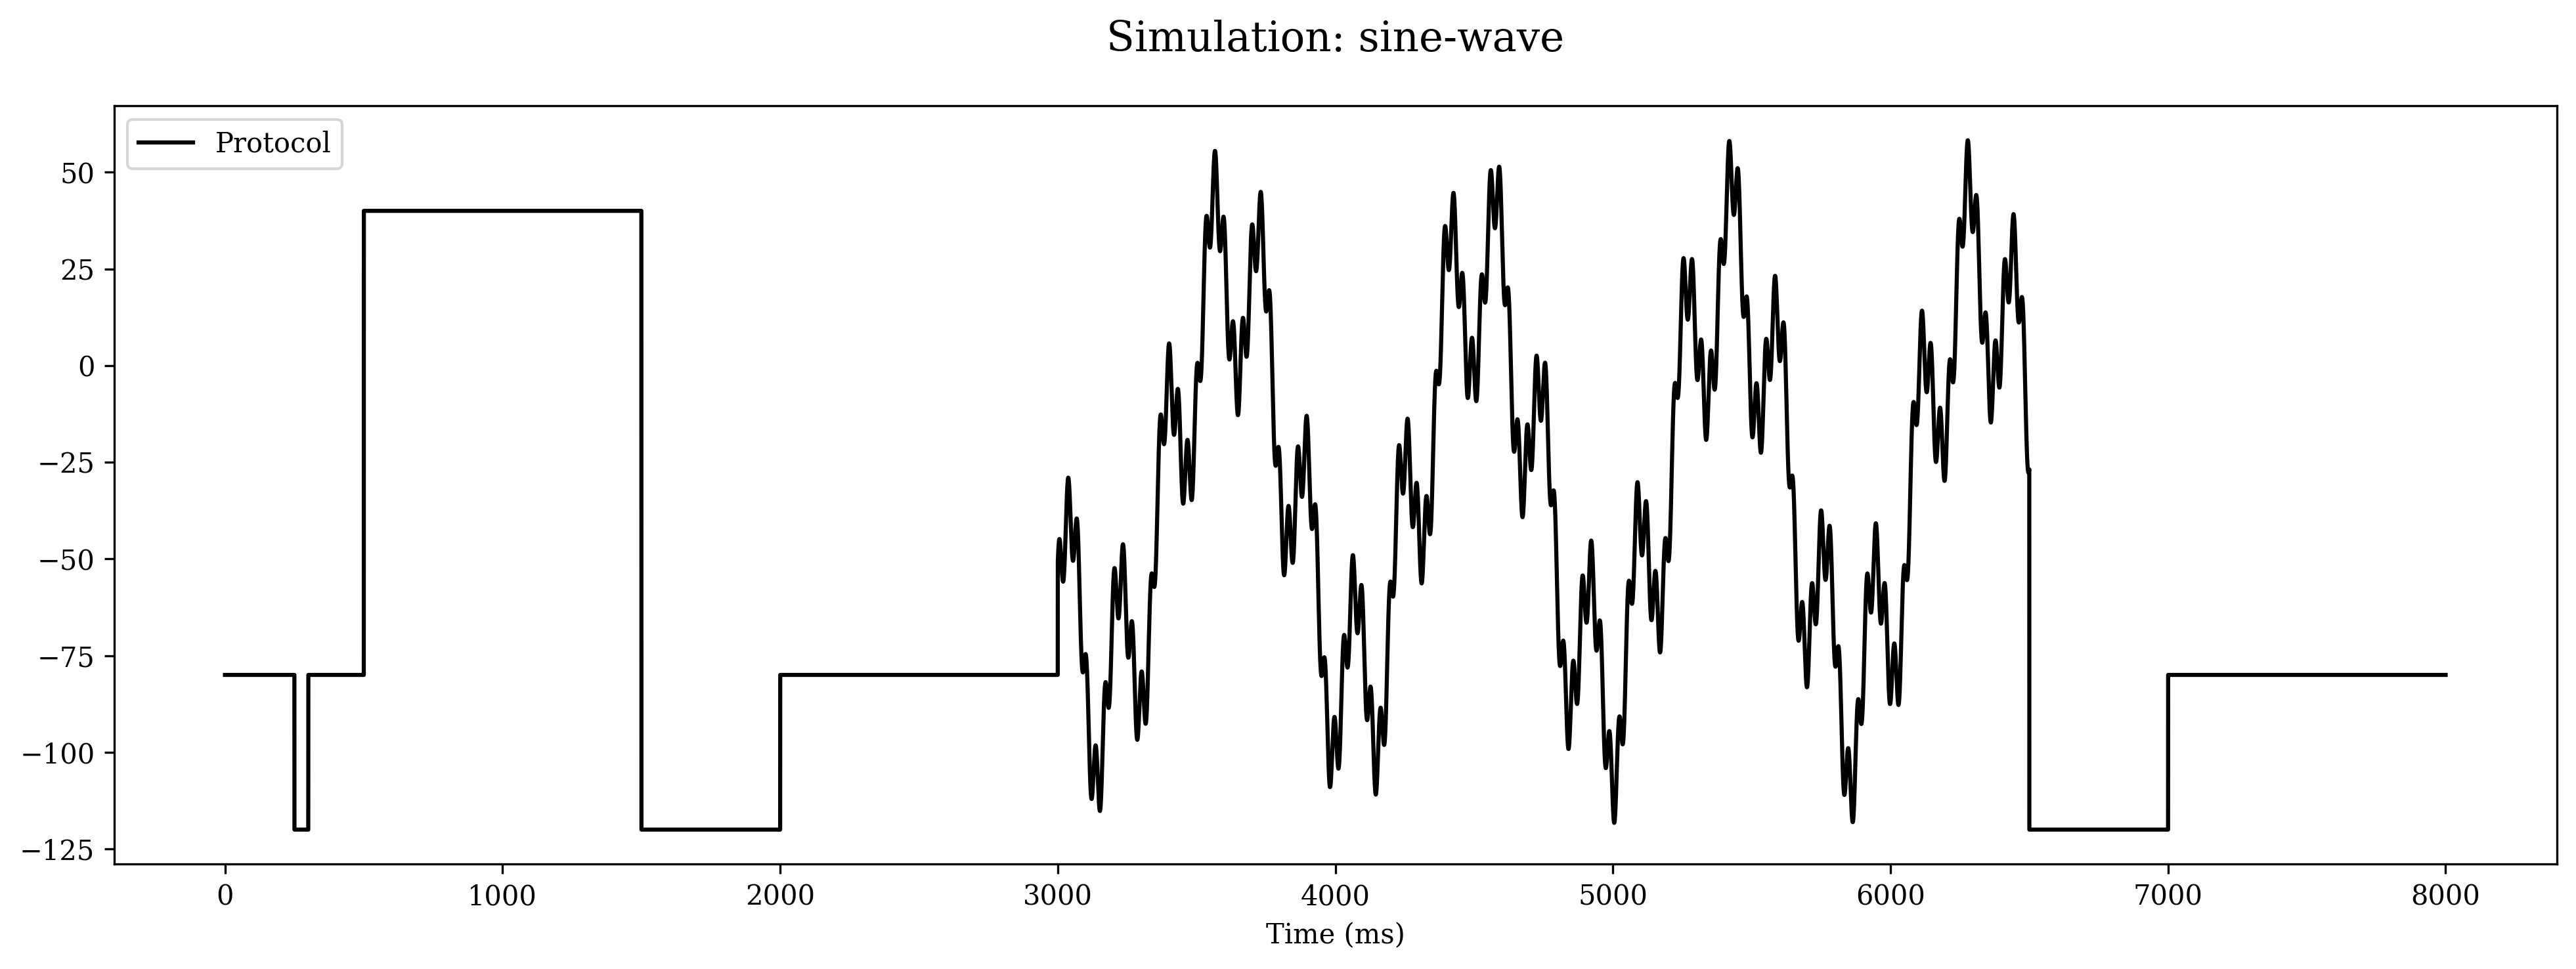

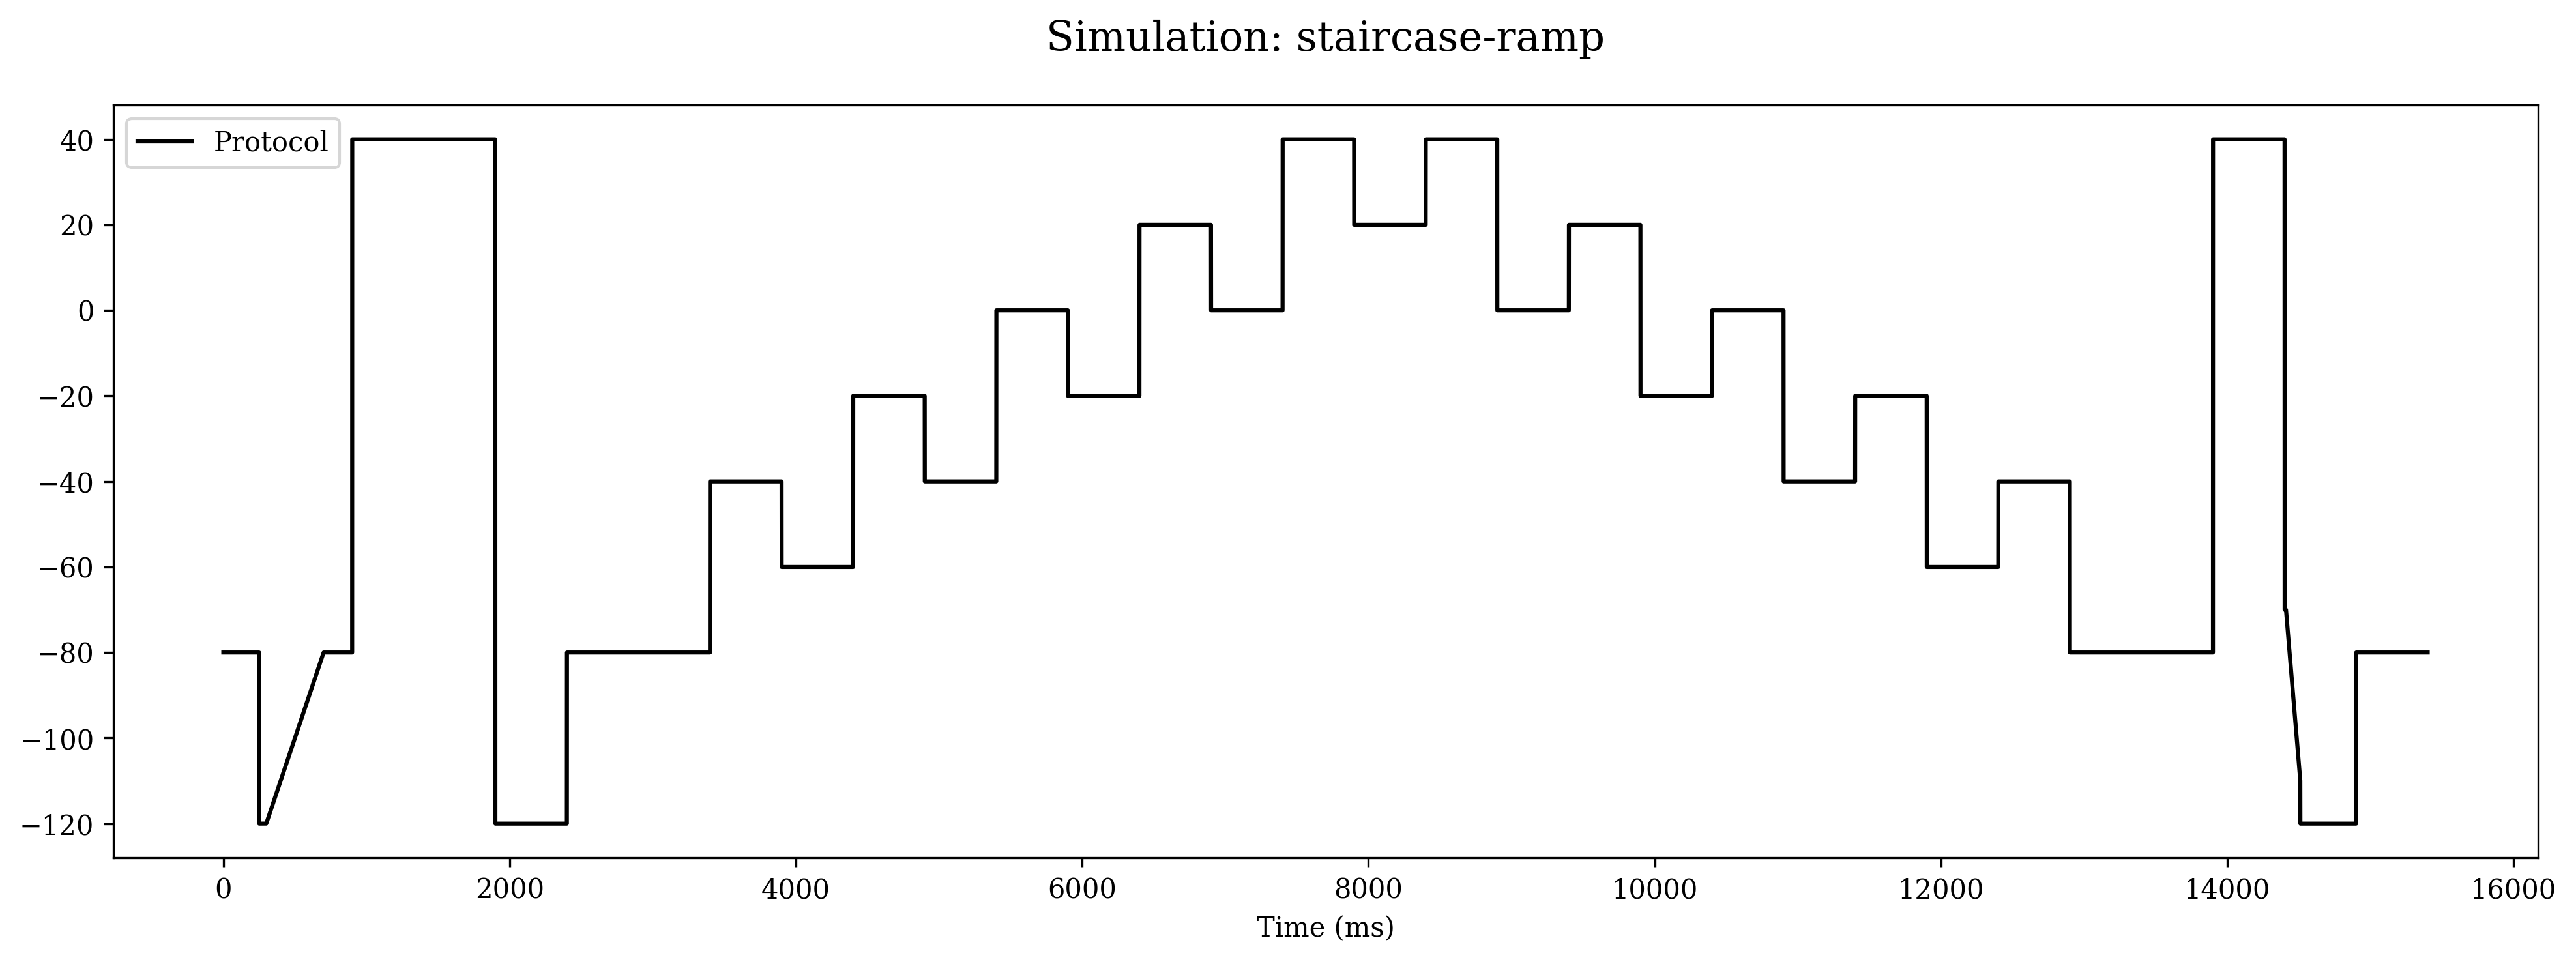

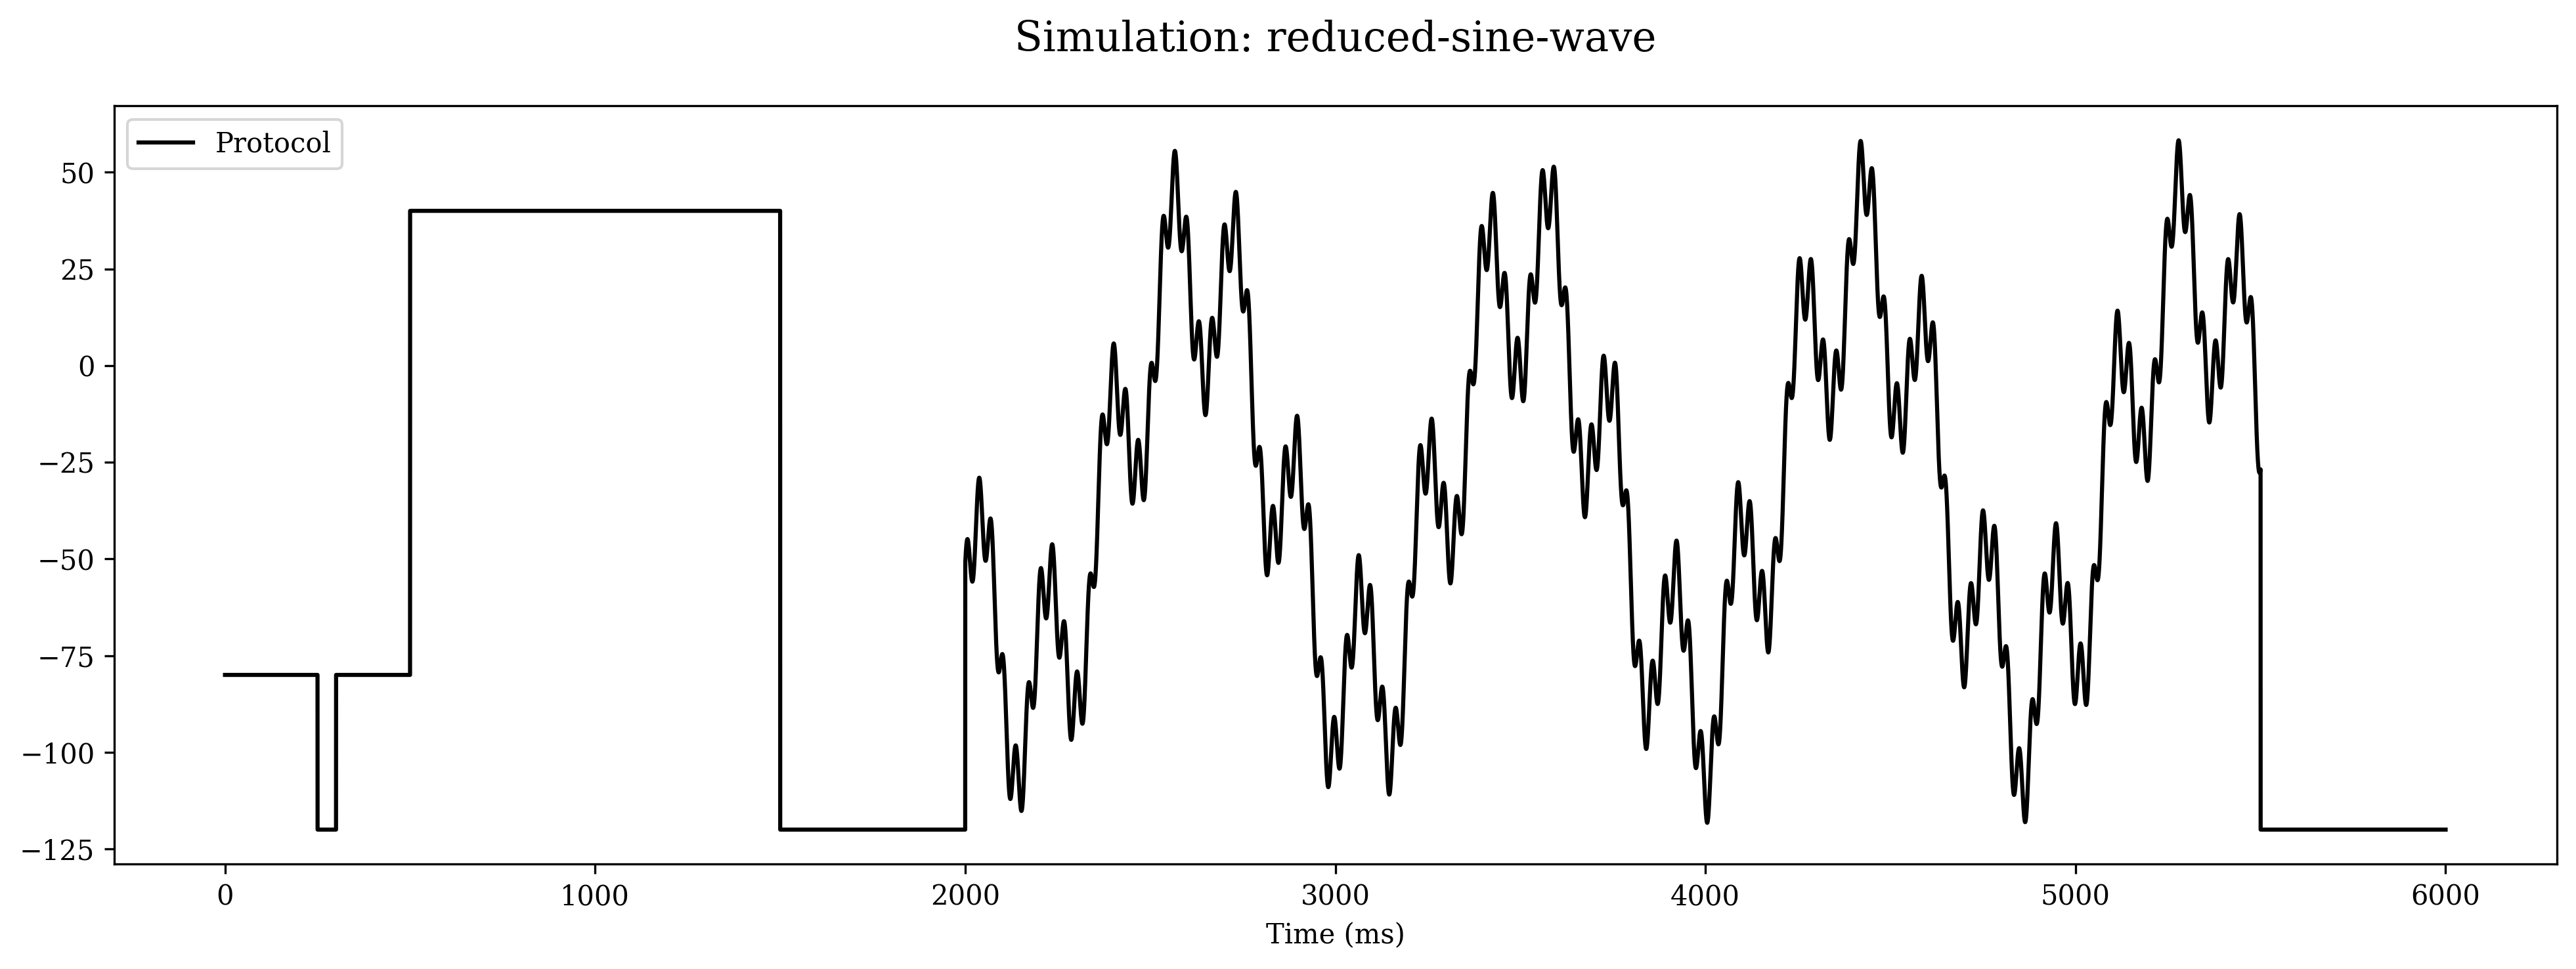

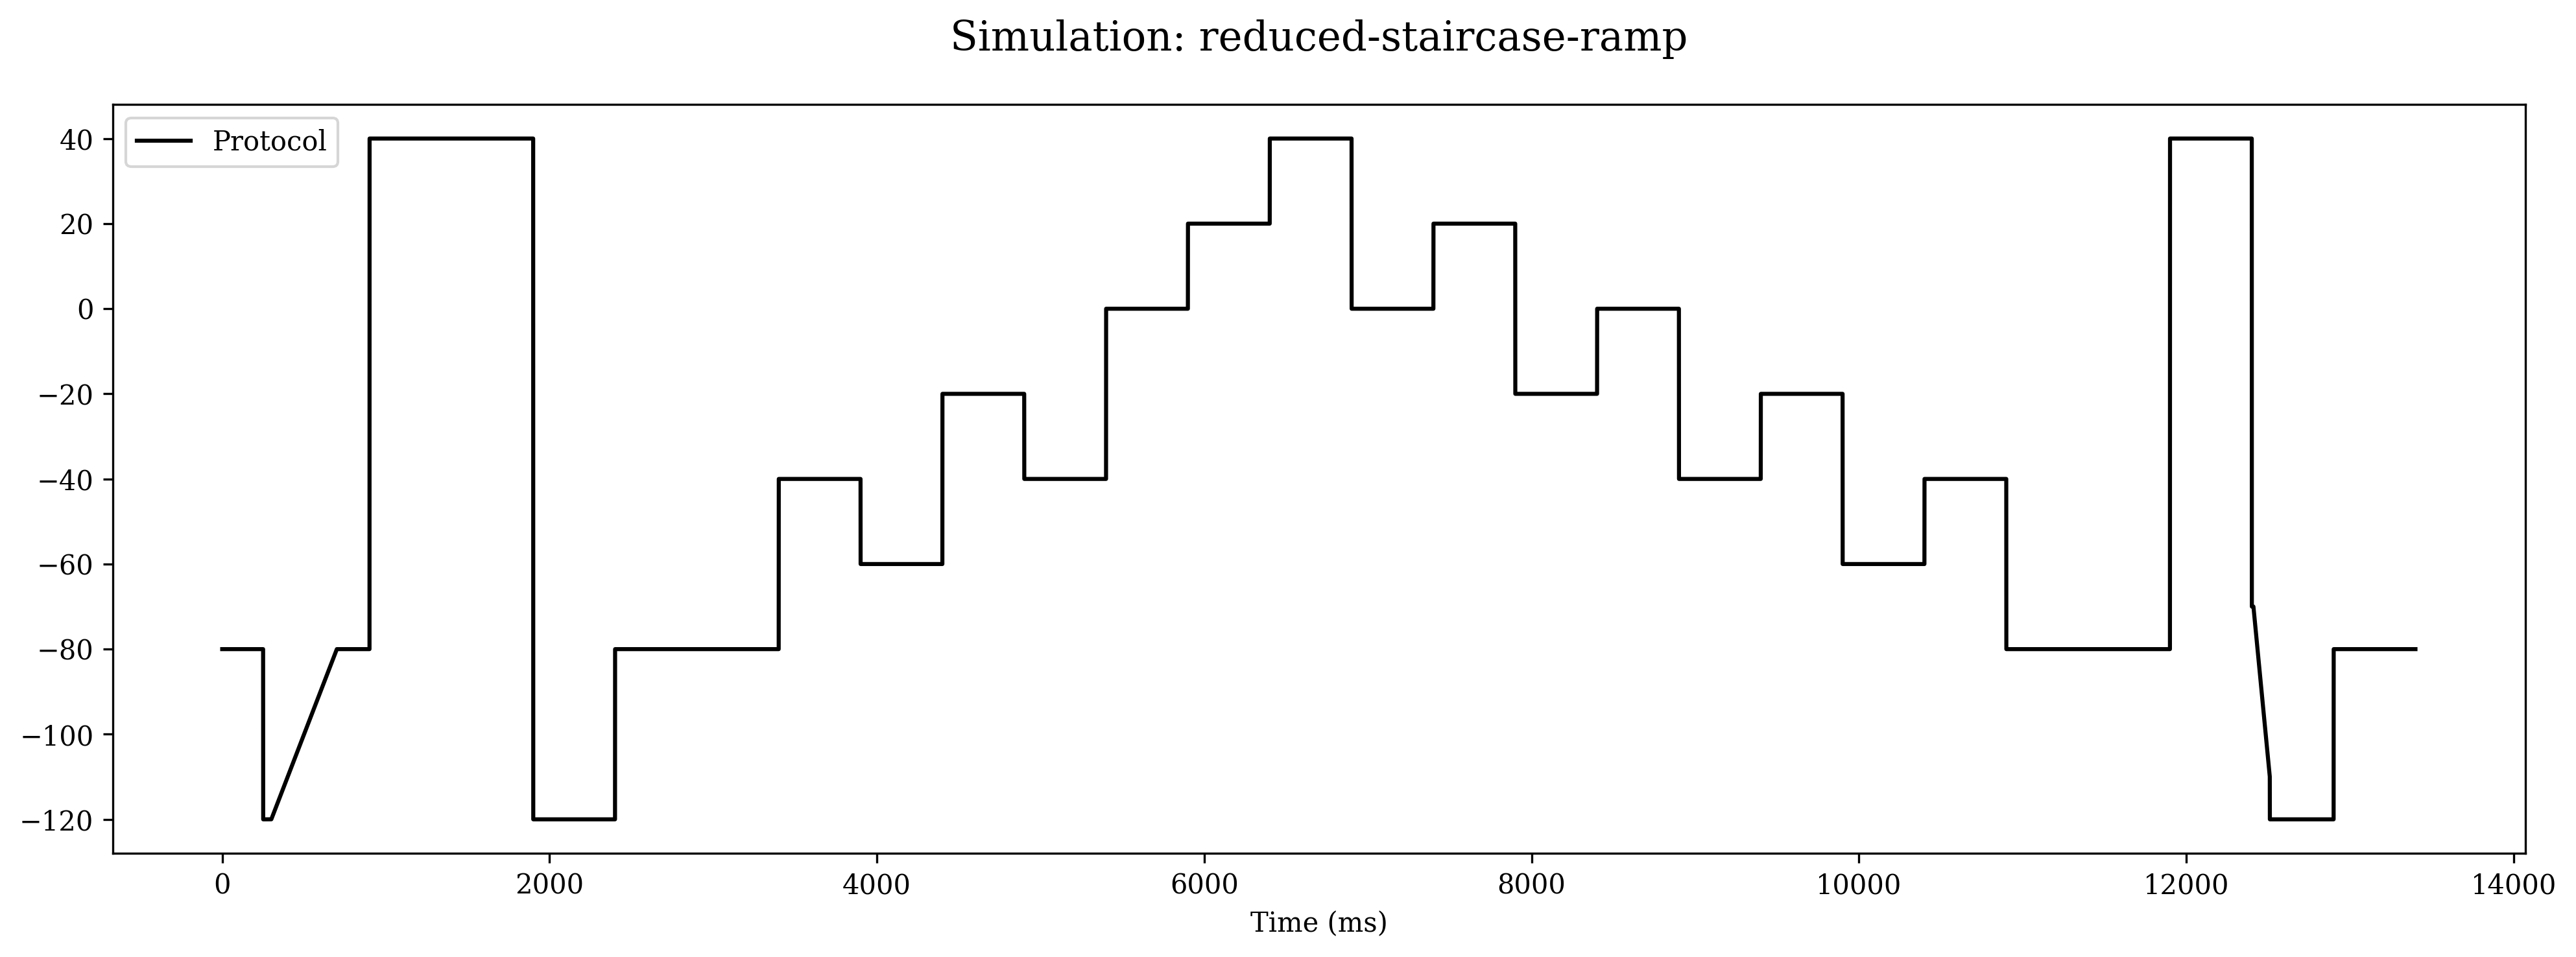

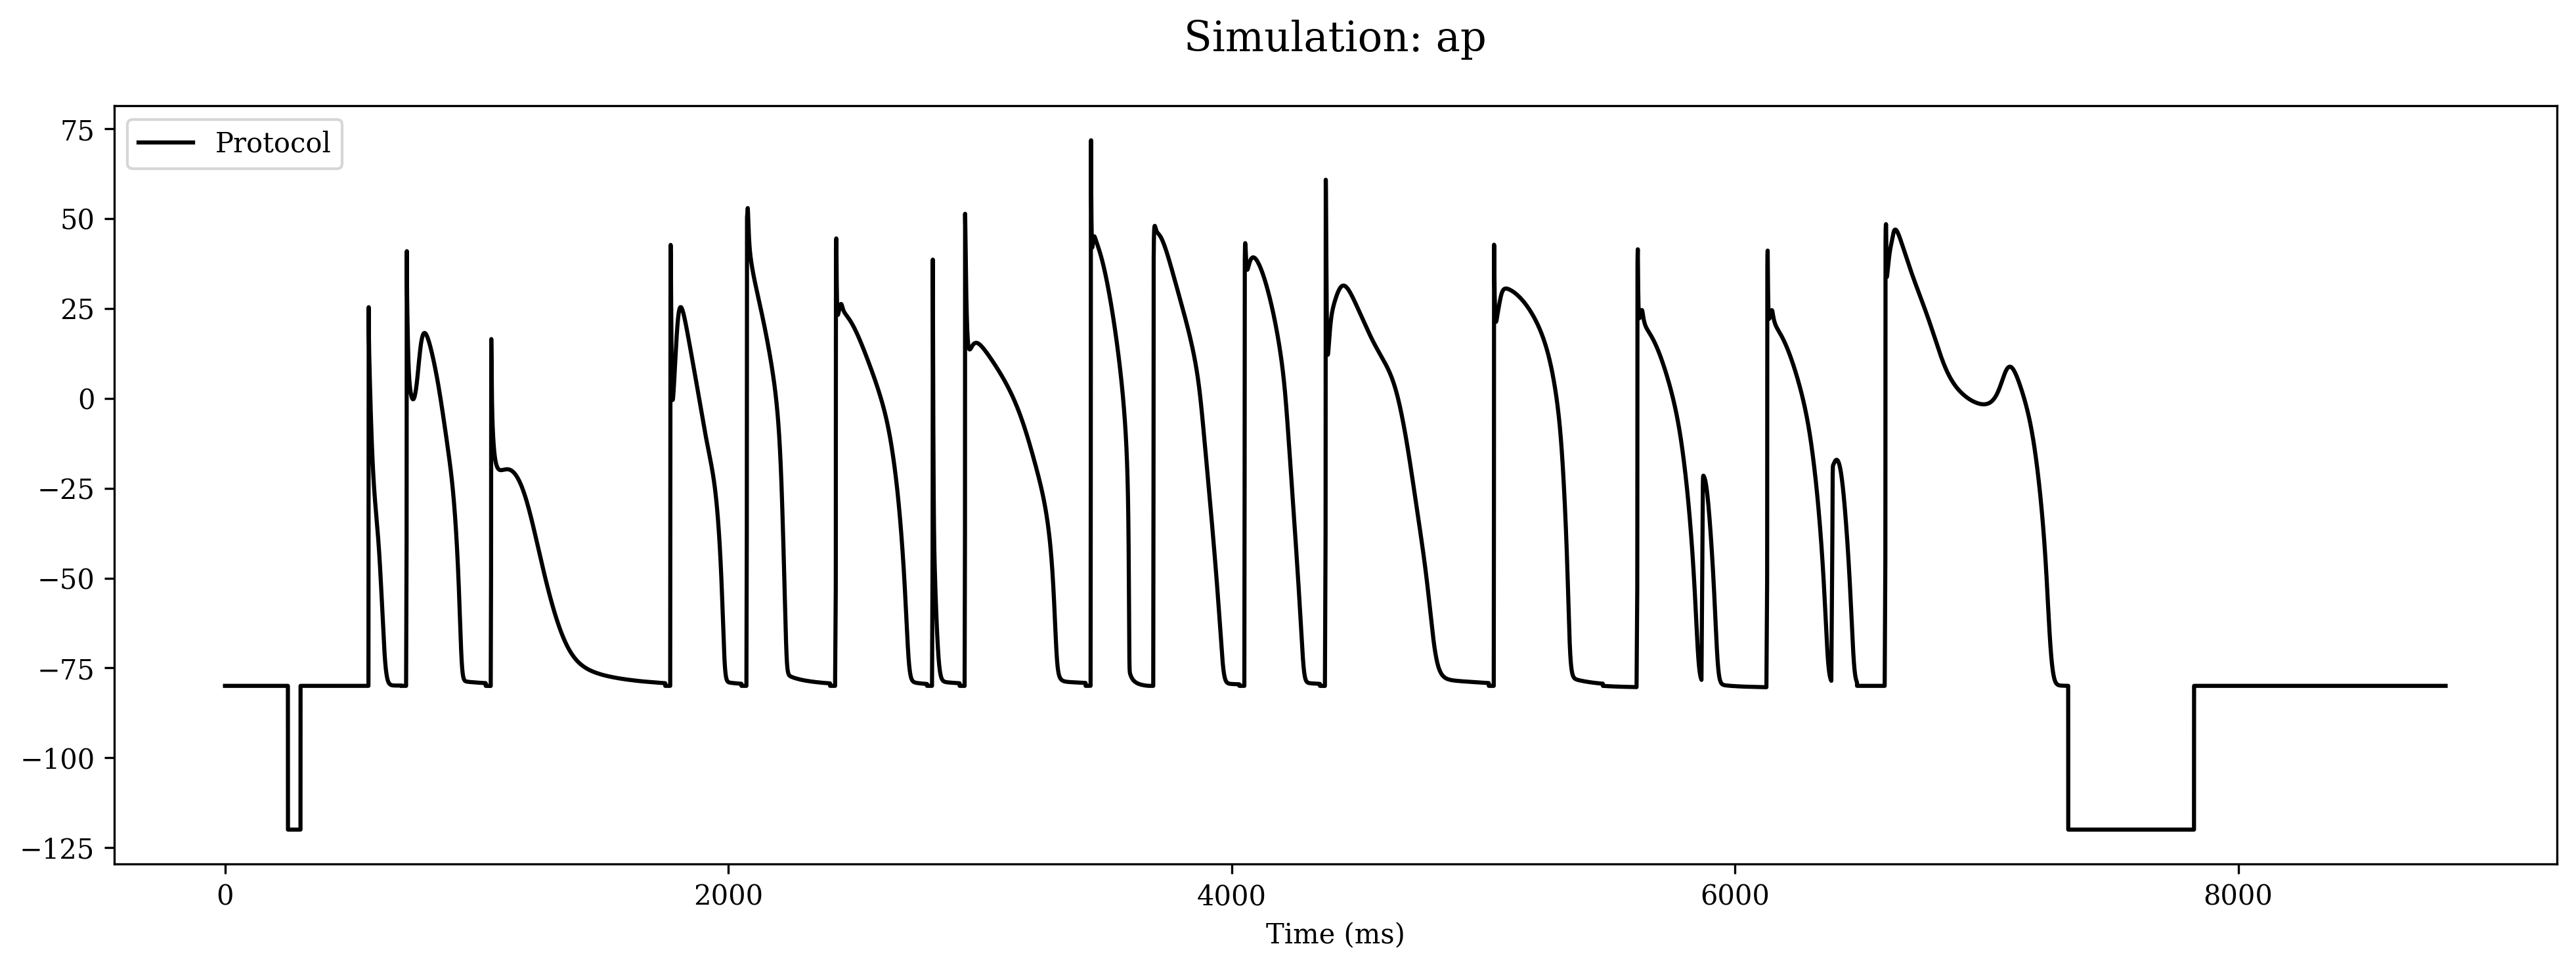

In [12]:
simulations = {}
test_models = {
    'model-C':"../models/model-C.mmt",
}

test_protocols = {
    "sine-wave":"../protocols/sine-wave.csv",
    "staircase-ramp":"../protocols/staircase-ramp.csv",
    "reduced-sine-wave":"../protocols/reduced-sine-wave.csv",
    "reduced-staircase-ramp":"../protocols/reduced-staircase-ramp.csv",
    "ap":"../protocols/ap.csv",
}

for model_name, model_path in test_models.items():
    for protocol_name, protocol_path in test_protocols.items():
        model = myokit.load_model(model_path)
        simulation = myokit.Simulation(model)
        dataLog = myokit.DataLog.load_csv(protocol_path).npview()
        time = dataLog['time']
        voltage = dataLog['voltage']

        simulation.set_fixed_form_protocol(time, voltage)

        timeMax = time[-1] + 1
        simulationLog = simulation.run(timeMax, log_times=time)

        try:
            simulations[protocol_name][model_name] = simulationLog
        except KeyError:
            simulations[protocol_name] = {}
            simulations[protocol_name][model_name] = simulationLog

for protocol_name, simulation_model in simulations.items():
    plt.figure(figsize=(16,10))

    plt.subplot(2,1,1)
    plt.title("Simulation: {}".format(protocol_name), pad=20, fontsize=15, **plt_font)
    plt.xlabel('Time (ms)', **plt_font)
    plt.xticks(**plt_font)
    plt.yticks(**plt_font)
    plt.plot(simulation_model['model-C']['engine.time'], simulation_model['model-C']['membrane.V'], label='Protocol', color='black')
    plt.legend(loc='upper left', prop={'family': 'DejaVu Serif'})

    plt.subplot(2,1,2)
    plt.xlabel('Time (ms)')
    plt.ylabel('Current (nA)')
    plt.xticks(**plt_font)
    plt.yticks(**plt_font)
    for model_name, simulationLog in simulation_model.items():
        plt.plot(simulationLog['engine.time'], simulationLog['ikr.IKr'], label='Simulation: {}'.format(model_name), color='black')
    plt.legend(loc='upper left', prop={'family': 'DejaVu Serif'})

    plt.show()

### 4. Creating synthetic noise data
Create action potential data and add synthetic noise for experiment.

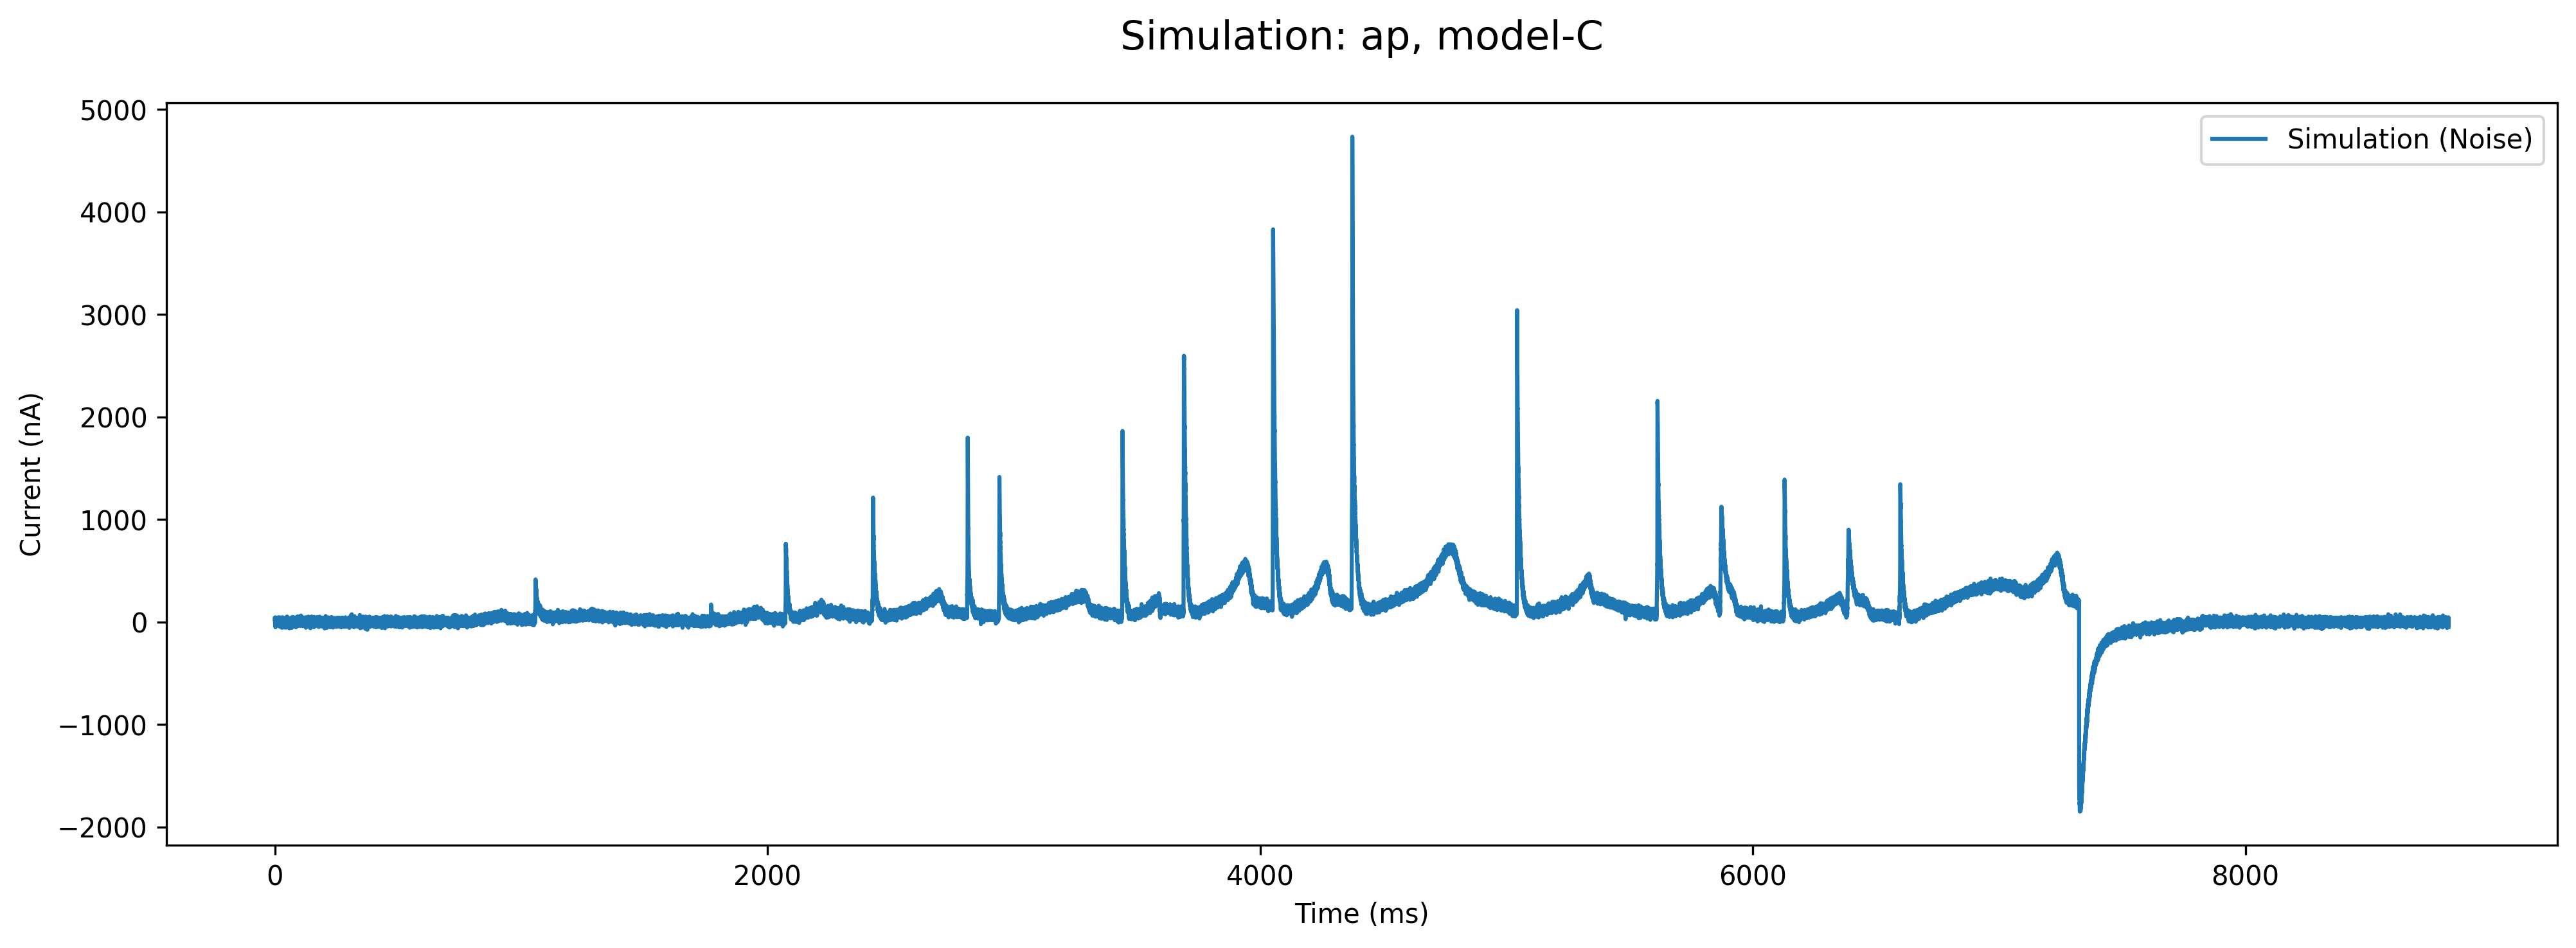

In [20]:
for protocol_name, simulation_model in simulations.items():
    for model_name, simulation_log in simulation_model.items():

        # Fix random seed for numpy
        np.random.seed(0)
        noise_current = simulation_log['ikr.IKr'] + np.random.normal(0, 20, len(simulation_log['ikr.IKr']))
        df = pd.DataFrame({
            'time' : simulation_log['engine.time'],
            'voltage' : simulation_log['membrane.V'],
            'current' : noise_current
        })
        df.to_csv(synthetic_path.format(protocol_name, model_name), index=False)

        dataLog = myokit.DataLog.load_csv(synthetic_path.format(protocol_name, model_name)).npview()

        plt.figure(figsize=(16,5))

        plt.title("Simulation: {}, {}".format(protocol_name, model_name), pad=20, fontsize=15)
        plt.xlabel('Time (ms)')
        plt.ylabel('Current (nA)')
        plt.plot(dataLog['time'], dataLog['current'], label='Simulation (Noise)')
        plt.legend()

        plt.show()

### 5. Calibration
Ground truth: `model-C`
Fit parameters of `model-A`, `model-B` to synthetic `model-C` data.

In [ ]:
import model
import boundaries
import importlib

importlib.reload(boundaries)

boundaries_setting = {
    'model-A':[boundaries.Boundaries_Model_A(), boundaries.transformation_model_a()],
    'model-B':[boundaries.Boundaries_Model_B(), boundaries.transformation_model_b()],
    'model-15':[boundaries.Boundaries_Model_15(), boundaries.transformation_model_15()],
    'model-16':[boundaries.Boundaries_Model_16(), boundaries.transformation_model_16()],
    'model-25':[boundaries.Boundaries_Model_25(), boundaries.transformation_model_25()],
}

error_count = 0
iteration = 40  # Setting the iteration per one calibration setting
model_settings = ['model-15', 'model-16', 'model-25']   # List variable for setting the model to calibrate
protocol_settings = ['reduced-sine-wave', 'staircase-ramp', 'reduced-staircase-ramp']   # List variable for setting the protocol to calibrate
model_source = "model-C"  # model for ground truth (model-C)


for protocol_setting in protocol_settings:
    for model_setting in model_settings:
        for i in tqdm(range(iteration)):
            # Create a model
            pints_model = model.Model(models[model_setting], synthetic_path.format(protocol_setting, model_source))
            pints_model.set_tolerance(1e-08)

            # Set up a problem, and define an error measure
            problem = pints.SingleOutputProblem(pints_model, pints_model.time, pints_model.current)
            error = pints.MeanSquaredError(problem)

            # Set up parameters randomly
            p0 = s0 = float('inf')
            while not np.isfinite(s0):
                p0 = boundaries_setting[model_setting][0].sample(1)[0]
                s0 = error(p0)

            # Create an optimisation controller
            opt = pints.OptimisationController(error, p0, boundaries=boundaries_setting[model_setting][0], transformation=boundaries_setting[model_setting][1], method=pints.CMAES)

            # Enable parallelization (multi-processing) / Logging interval
            opt.set_parallel(True)
            opt.set_log_interval(iters=500, warm_up=0)
            # Run the optimisation
            with np.errstate(all='ignore'):
                try:
                    xbest, fbest = opt.run()
                except ValueError:
                    error_count += 1
                    print("Parameter error detected!\nError count: {}".format(error_count))
                    continue
            parameters_list = []
            for p in range(pints_model.n_parameters()):
                parameters_list.append("p" + str(p+1))
            df = pd.DataFrame([[fbest, opt.time(), opt.iterations(), opt.evaluations(), *xbest.tolist()]], columns=['error', 'time', 'iterations', 'evaluations']+parameters_list)
            df.to_csv(output_path.format(protocol_setting, model_setting), mode='a', index=False, header=not os.path.exists(output_path.format(protocol_setting, model_setting)))
            print()

    print("Fitting completed!")

### 6. Check the result
Automatically checks the best fitting case of the previous calibration.

MSE: 1122.9214800343136


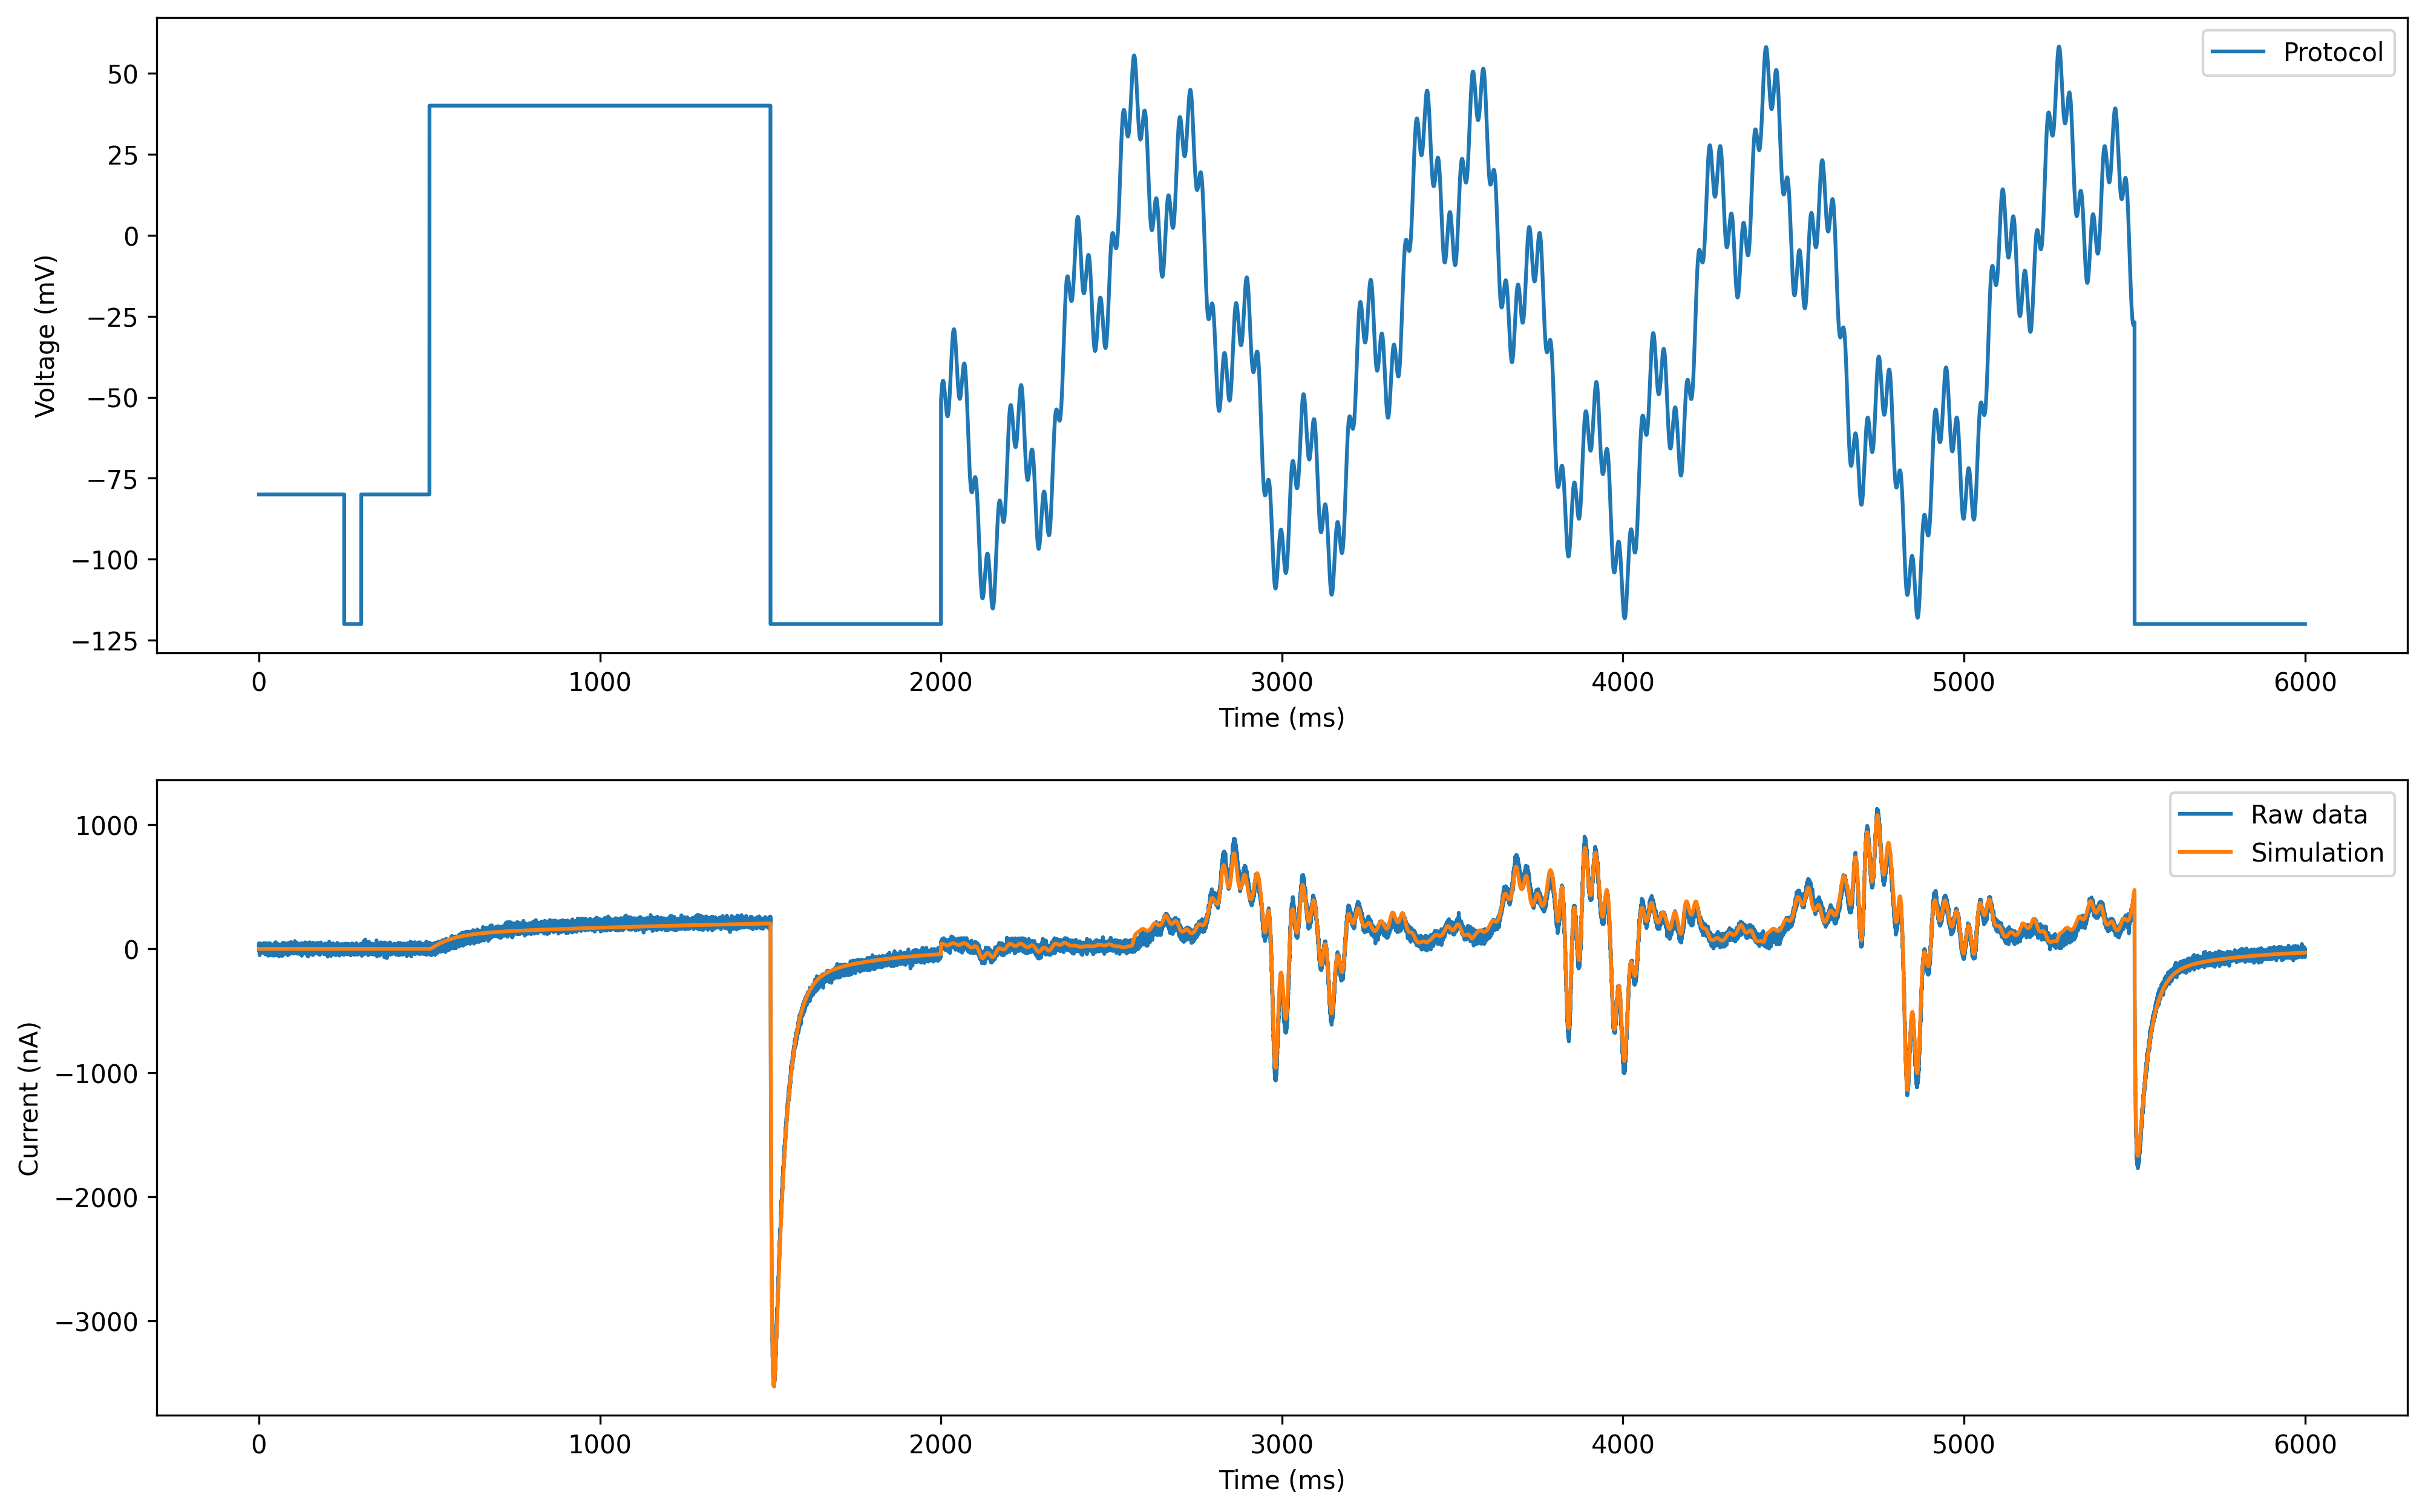

In [25]:
model_source = "model-C"
model_setting = "model-16"
protocol_setting = "reduced-sine-wave"

pints_model = model.Model(models[model_setting], synthetic_path.format(protocol_setting, model_source))
df = pd.read_csv(output_path.format(protocol_setting, model_setting)).sort_values(by='error', ascending=True).iloc[0]

view_parameters = []
for i in range(pints_model.n_parameters()):
    view_parameters.append(df['p{}'.format(i+1)])

log = pints_model.simulate(view_parameters, pints_model.time)

# Set up a problem, and define an error measure
problem = pints.SingleOutputProblem(pints_model, pints_model.time, pints_model.current)
error = pints.MeanSquaredError(problem)
print("MSE:", error(view_parameters))

plt.figure(figsize=(16,10))

plt.subplot(2,1,1)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.plot(pints_model.time, pints_model.voltage, label='Protocol')
plt.legend()

plt.subplot(2,1,2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
plt.plot(pints_model.time, pints_model.current, label='Raw data')
plt.plot(pints_model.time, log, label='Simulation')
plt.legend()

plt.show()